# Pipeline

1.   Load Data and create Data Frame

2.   Preprocessing

3.   Exploration and Data analysis

4.   Bag of Words
    1. Vectorizer
    2. Kmeans
    3. Interpretation

5. Entity Linking 
    1. Vectorizer
    2. Kmeans
    3. Interpretation


In [ ]:
! pip install coclust
! pip install spacy
#! python -m spacy download fr_core_news_sm
! python -m spacy download en_core_web_sm
! pip install spacy-transformers
! pip install spacy-entity-linker
! python -m spacy_entity_linker "download_knowledge_base"

In [ ]:
!python -m spacy download en_core_web_lg

# Packages

In [ ]:
import pandas as pd
import string
import re
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as pltg
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import nltk
from coclust.clustering.spherical_kmeans import SphericalKmeans
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
sp = spacy.load('en_core_web_lg')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data and create data frame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/DBLP_Subset.txt") as f:
  data = f.read()
na_authors, na_years, na_pubs, na_index, na_refs, na_abstracts = [0]*6
docs = data.split("#*")[1:]
for doc in docs:
  if "#@" not in doc:
    na_authors +=1
  if "#t" not in doc:
    na_years+=1
  if "#c" not in doc:
    na_pubs+=1
  if "#index" not in doc:
    na_index+=1
  if "#%" not in doc:
    na_refs+=1
  if "#!" not in doc:
    na_abstracts+=1
print("The number of documents: ", len(docs), "\n")
print("The number of missing authors: ", na_authors, "\n")
print("The number of missing years: ", na_years, "\n")
print("The number of missing publications: ", na_pubs, "\n")
print("The number of missing index: ", na_index, "\n")
print("The number of missing references: ", na_refs, "\n")
print("The number of missing abstracts: ", na_abstracts, "\n")

The number of documents:  37963 

The number of missing authors:  0 

The number of missing years:  0 

The number of missing publications:  0 

The number of missing index:  0 

The number of missing references:  19217 

The number of missing abstracts:  17406 



In [ ]:
num_doc = 0
docs_dict = {}
for doc in docs:

  title = ""
  authors = ""
  year = 0
  publication_revue = ""
  index = 0
  references = np.nan
  abstracts = np.nan

  title = doc[0:doc.find("#@")].replace("\n", "")
  authors = doc[doc.find("#@")+2:doc.find("#t")-1].split("\n")
  authors = ",".join(authors)
  year = int(doc[doc.find("#t")+2:doc.find("#c")].replace("\n", ""))
  publication_revue = doc[doc.find("#c")+2:doc.find("#index")].replace("\n","")
  if doc[doc.find("#index")+6:].find("#%") == -1 and doc[doc.find("#index")+6:].find("#!") == 1:
    # no abstract and no references
    index = int(doc[doc.find("#index")+6:].replace("\n",""))
  elif doc[doc.find("#index")+6:].find("#%") != -1:
    # only references
    index = int(doc[doc.find("#index")+6:doc.find("#%")].replace("\n","")) 
  elif  doc[doc.find("#index")+6:].find("#!") != -1:
    # only abstracts
    index = int(doc[doc.find("#index")+6:doc.find("#!")].replace("\n","")) 
  if "#%" in doc:
    references = doc[doc.find("#%")+2:doc.find("#!")].replace("\n","") # return -1 if no #!(abstract)
    references = references.split("#%")
    references = ", ".join(references)
  if "#!" in doc:
    abstracts = doc[doc.find("#!")+2:].replace("\n", "")
  docs_dict[num_doc] = [title, authors, year, publication_revue, index, references, abstracts]
  num_doc +=1

df = pd.DataFrame(docs_dict)
df = df.T
df.columns = ["Title", "Authors", "Year", "Publication", "Index", "References", "Abstract"] 
df

,Title,Authors,Year,Publication,Index,References,Abstract
0,Improved Channel Routing by Via Minimization a...,"Chung-Kuan Cheng,David N. Deutsch",1988,DAC,131751,"133716, 133521, 134343",Channel routing area improvement by means of v...
1,A fast simultaneous input vector generation an...,"Lei Cheng,Liang Deng,Deming Chen,Martin D. F. ...",2006,DAC,131752,"132550, 530568, 436486, 134259, 283007, 134422...",Input vector control (IVC) technique is based ...
2,On the Over-Specification Problem in Sequentia...,"Kwang-Ting Cheng,Hi-Keung Tony Ma",1992,DAC,131756,"455537, 1078626, 131745",The authors show that some ATPG (automatic tes...
3,Device and architecture co-optimization for FP...,"Lerong Cheng,Phoebe Wong,Fei Li,Yan Lin,Lei He",2005,DAC,131759,"214244, 215701, 214503, 282575, 214411, 214505...",Device optimization considering supply voltage...
4,Differential Fault Simulation - a Fast Method ...,"Wu-Tung Cheng,Meng-Lin Yu",1989,DAC,131760,"131744, 806030",A new fast fault simulator called differential...
...,...,...,...,...,...,...,...
37958,Selection of strategies in judgment-based effo...,Magne Jørgensen,2010,Journal of Systems and Software,1600529,"996865, 601059, 361510, 492786, 997634, 112851...",We currently know little about the factors tha...
37959,Performance analysis of opportunistic broadcas...,"Abbas Nayebi,Hamid Sarbazi-Azad,Gunnar Karlsson",2010,Journal of Systems and Software,1600531,"505564, 1114157, 412964, 588689, 53668, 692884...",This paper investigates a class of mobile wire...
37960,Quality adaptive end-to-end packet scheduling ...,"Rossella Fortuna,Luigi Alfredo Grieco,Gennaro ...",2010,Journal of Systems and Software,1600532,"396959, 794228, 588835, 997951",In Internet multimedia streaming the quality o...
37961,Design and evaluation of a novel MAC layer han...,"Richard Werner Nelem Pazzi,Zhenxia Zhang,Azzed...",2010,Journal of Systems and Software,1600537,"666821, 784037, 506991, 505779, 1247751",In recent years the IEEE 802.11 wireless netwo...


In [ ]:
# There are some documents that dont'have publications and abstracts, we replace this by nan value
df.isna().sum()

Title              0
Authors            0
Year               0
Publication        0
Index              0
References     19217
Abstract       17406
dtype: int64

# Preprocessing

In this part, we use 03 methods to preprocess our dataset:

1. Delete raws which have no abstract in our data frame.

2. Drop all revues which don't have more than 50 publications

3. Clean abstracts for using some basic methods:
   
   - Remove stopwords

   - Remove mentions

   - Remove hastags

   - Remove punctuations

   - Remove numbers and replace over spaces

In [ ]:
# Drop Raws that have no abstracts
df.dropna(subset = ["Abstract"], inplace=True)
df.isna().sum()

Title             0
Authors           0
Year              0
Publication       0
Index             0
References     2452
Abstract          0
dtype: int64

In [ ]:
# delete nan values in references by 0
df.dropna(subset=['References'], inplace=True)
df.isna().sum()

Title          0
Authors        0
Year           0
Publication    0
Index          0
References     0
Abstract       0
dtype: int64

In [ ]:
# Drop journals which have a number of publications < 50
df=df.groupby('Publication').filter(lambda x : (x['Publication'].count()>=50).any())
df['Publication'].value_counts()

DAC                                  2031
Electr. Notes Theor. Comput. Sci.    1909
IJCAI                                1905
ICCAD                                1666
SIGMOD Conference                    1627
GECCO                                1472
Discrete Applied Mathematics         1335
Journal of Systems and Software       916
ICIP                                  812
Des. Codes Cryptography               648
ICC                                   587
SIGMOD Record                         510
SMC                                   325
GECCO (Companion)                     269
Distributed Computing                 224
DATA BASE                             214
Data Min. Knowl. Discov.              181
ICCSA (1)                             152
ICCSA (2)                             145
ICCSA (3)                             144
IJCAI (1)                              83
ICCV                                   76
STOC                                   73
ICCBR                             

In [ ]:
# Preprocessing of abstracts
def preprocessing(corpus):
    for i in range(len(corpus)):
        sentence = str(corpus[i])
        sentence = sentence.lower()
        # remove stopwords
        sentence = ' '.join([word for word in sentence.split() if word not in stopwords.words('english')])
        # remove mentions (@...)
        sentence = re.sub("@\S+", " ", sentence)
        # remove url
        sentence = re.sub("https*\S+", " ", sentence)
        # remove hashtags (#...)
        sentence = re.sub("#\S+", " ", sentence)
        # remove puncuations
        sentence = re.sub("[%s]"%re.escape(string.punctuation), " ", sentence)
        # remove numbers 
        sentence = re.sub(r'\w*\d+\w*', ' ', sentence)
        # replace over spaces ( plusieurs espaces)
        sentence = re.sub('\s{2,}', " ", sentence)
        # delete character with len 
        sentence = sentence.split()
        sentence = ' '.join([word for word in sentence if len(word) > 2])
        lemmas = []
        l = sp(sentence)
        for word in l:
          lemmas.append(word.lemma_)
        sentence = ' '.join(lemmas)
        corpus[i] = sentence
    return corpus
    
df.iloc[:,6] = preprocessing(df.iloc[:,6].values)

# Exploration and Data analysis

In [ ]:
# Top 100 of authors who have participated on more publication
authors = df.iloc[:,1].values
authors = " ".join(authors)
corp = authors.split(", ")
freq = nltk.FreqDist(corp)
dict_freq = {}
for key, value in freq.items():
  dict_freq[key] = [key, value]

data_frame_freq = pd.DataFrame(dict_freq)
data_frame_freq = data_frame_freq.transpose()
data_frame_freq.columns = ['Author','Number of publications']

px.bar(data_frame_freq.sort_values(by="Number of publications", ascending=False).iloc[:100,:], x='Author', y='Number of publications', 
       title='Top 100 of authors', template='plotly_white', labels={'Author':'Author', 'Number of publications':'Number of publications'})

In [ ]:
# The most popular articles (number of references)
citations = df.iloc[:,5].values
nb_citations = []
for i in range(len(citations)):
  citation = str(citations[i])
  if len(citation.split()) == 1:
    nb_citations.append(0)
  else:
    nb_citations.append(len(citation.split()))
nb_citations.sort(reverse=True)
px.bar(x=df.iloc[:,0].values[:50], y=nb_citations[:50], title="Top 50 of the most popular articles",labels={"x":"Articles", "y":"Number of citations"})

In [ ]:
# Number of publication per year
px.histogram(data_frame=df, x="Year",title="Number of publication per Year")

In [ ]:
# Number of publication of each revue
publications = df.Publication.value_counts()
values = publications.values
keys = publications.keys()
px.bar(x=keys, y=values, title="Number of publication of each revue")

In [ ]:
# Distribution of number of citation

In [ ]:
# Word cloud of abstracts after preprocessing
corpus = df.copy().iloc[:,6]
wordcloud = WordCloud(background_color="white")
text = " ".join(corpus) 
wordcloud.generate(text)
px.imshow(wordcloud)

In [ ]:
# Frequency of each term  of abstract on the corpus
corpus = df.copy().iloc[:,6]
texts = " ".join(corpus)
			
corp = texts.split()
freq = nltk.FreqDist(corp)
dict_freq = {}
for key, value in freq.items():
  dict_freq[key] = [key, value]

data_frame_freq = pd.DataFrame(dict_freq)
data_frame_freq = data_frame_freq.transpose()
data_frame_freq.columns = ['word','count']

px.bar(data_frame_freq.sort_values(by="count", ascending=False).iloc[:100,:], x='word', y='count', title='Word frequency on corpus', 
template='plotly_white', labels={'word':'Words', 'count':'Count'})

# Bag of words

## Kmeans

In [ ]:
# Bag of words 
vectorizer = CountVectorizer() 
X_bag_of_word = vectorizer.fit_transform(df.iloc[:,6].values)
X_bag_of_word.toarray().shape

(17633, 31871)

In [ ]:
# the number of columns is much greater than the number of rows
# SVD is more relevant is this case than PCA

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(500)
X_bag_of_word_svd = svd.fit_transform(X_bag_of_word.toarray())

In [ ]:
# Size of inertia on the 500 first components
svd.explained_variance_.sum()

105.59031976779717

In [ ]:
# search the optimal number of cluster for the kmeans
nb_clusters = range(2,11)
inertia_w = []
for n in nb_clusters:
  kmeans = KMeans(n_clusters=n,n_init=10, max_iter=300).fit(X_bag_of_word.tocsr())
  inertia_w.append(kmeans.inertia_)
px.line(x=range(2,11), y=inertia_w, title="Evolution of the inter-class inertia")

In [ ]:
# we use 4 for the number of clusters(given by the elbow method)
kmeans = KMeans(n_clusters=4,n_init=10, max_iter=300).fit(X_bag_of_word.tocsr())

In [ ]:
# Projection of articles in the 2 first axes for the svd with clusters detected by the kmeans
px.scatter(x=X_bag_of_word_svd[:,0],y=X_bag_of_word_svd[:,1], color=kmeans.labels_)

In [ ]:
import matplotlib.pyplot as plt

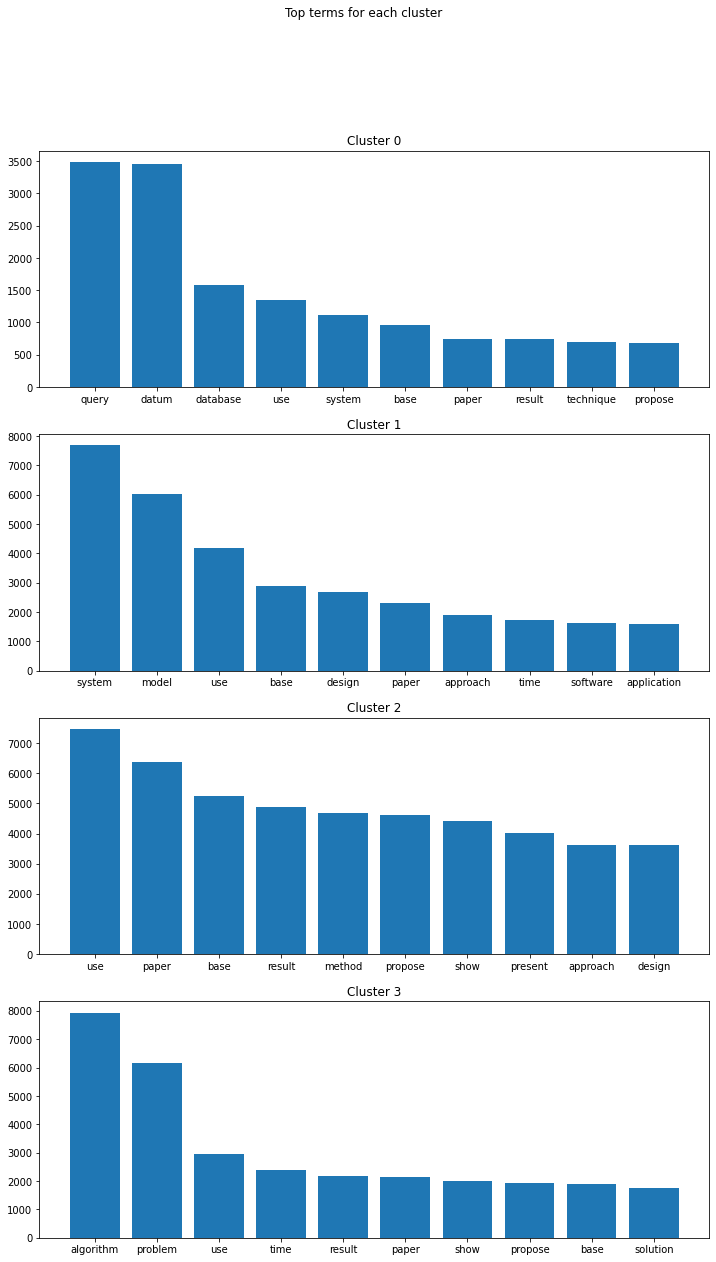

In [ ]:
# top terms for each cluster
fig, axes = plt.subplots(4)
fig.suptitle('Top terms for each cluster')
fig.set_figwidth(12)
fig.set_figheight(20)
for i in range(4):
  df_cluster = df.loc[kmeans.labels_==i, :]
  corpus = df_cluster.copy().iloc[:,6]
  texts = " ".join(corpus)
  
  corp = texts.split()
  freq = nltk.FreqDist(corp)
  dict_freq = {}
  for key, value in freq.items():
    dict_freq[key] = [key, value]

  data_frame_freq = pd.DataFrame(dict_freq)
  data_frame_freq = data_frame_freq.transpose()
  data_frame_freq.columns = ['word','count']
  data_frame_freq = data_frame_freq.sort_values(by="count", ascending=False)
  axes[i].bar(data_frame_freq.iloc[:,0].values[:10], data_frame_freq.iloc[:,1].values[:10])
  axes[i].set_title(f"Cluster {i}")
plt.show()

In [ ]:
# Type of revues for each cluster
revues_names = []
revues_counts = []
for i in range(4):
  df_cluster = df.loc[kmeans.labels_==i, :]
  print(f"The type of revues for the cluster {i} : {df_cluster.Publication.value_counts().keys()[0]}\n")


The type of revues for the cluster 0 : SIGMOD Conference

The type of revues for the cluster 1 : Electr. Notes Theor. Comput. Sci.

The type of revues for the cluster 2 : DAC

The type of revues for the cluster 3 : GECCO



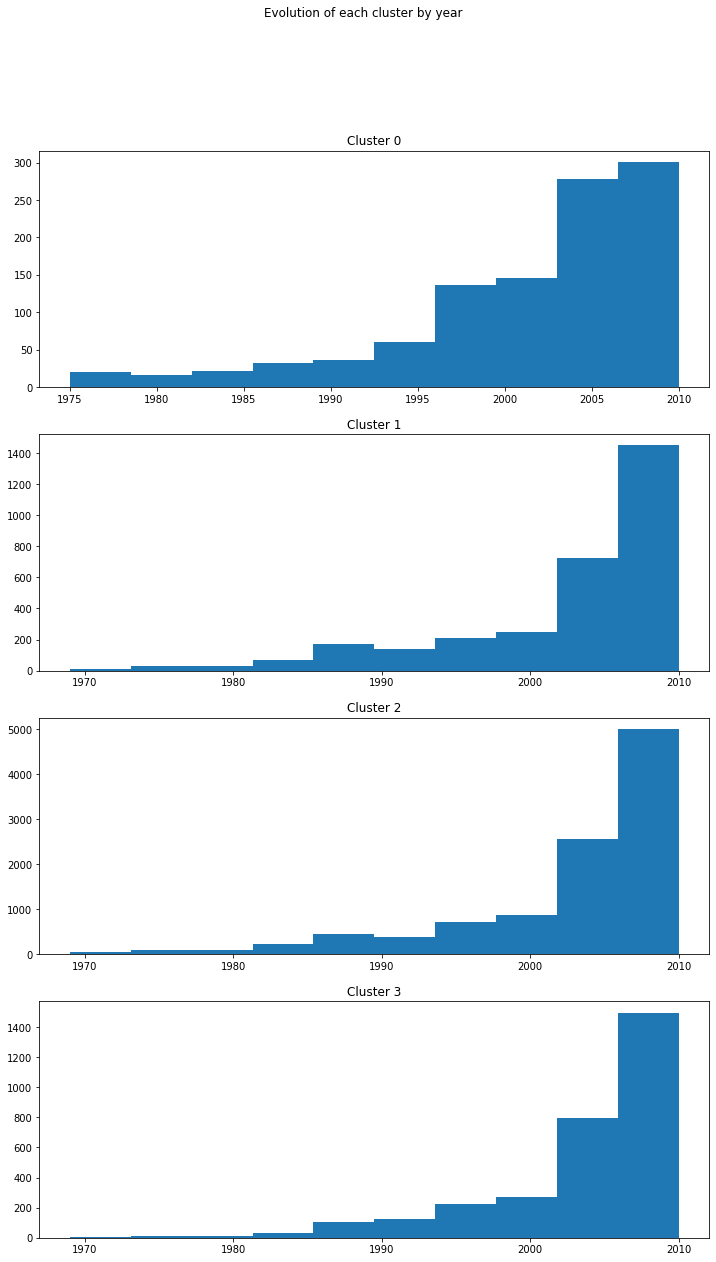

In [ ]:
# Evolution of each cluster by year
fig, axes = plt.subplots(4)
fig.suptitle('Evolution of each cluster by year')
fig.set_figwidth(12)
fig.set_figheight(20)
for i in range(4):
  df_cluster = df.loc[kmeans.labels_==i, :]
  axes[i].hist(df_cluster.Year.values)
  axes[i].set_title(f"Cluster {i}")
plt.show()

In [ ]:
# Number of citations(references) for each cluster
citations = []
for i in range(4):
  df_cluster = df.loc[kmeans.labels_==i, :]
  n = 0
  for citation in df_cluster.References.values:
    citation = str(citation)
    citation = citation.split()
    n+=len(citation)
  citations.append(n)
px.bar(x=[f'Cluster {i}' for i in range(4)], y=citations, title="Number of citations for each cluster")

## Spherical Kmeans

In [ ]:
# spherical kmeans on the package coclust
spherical_kmeans = SphericalKmeans(n_clusters=4,n_init=10, max_iter=20)
X = spherical_kmeans.fit(X_bag_of_word) # we can use a sparse matrix

In [ ]:
# Projection of articles in the 2 first axes for the svd with clusters detected by the spherical kmeans
px.scatter(x=X_bag_of_word_svd[:,0],y=X_bag_of_word_svd[:,1], color=spherical_kmeans.labels_)

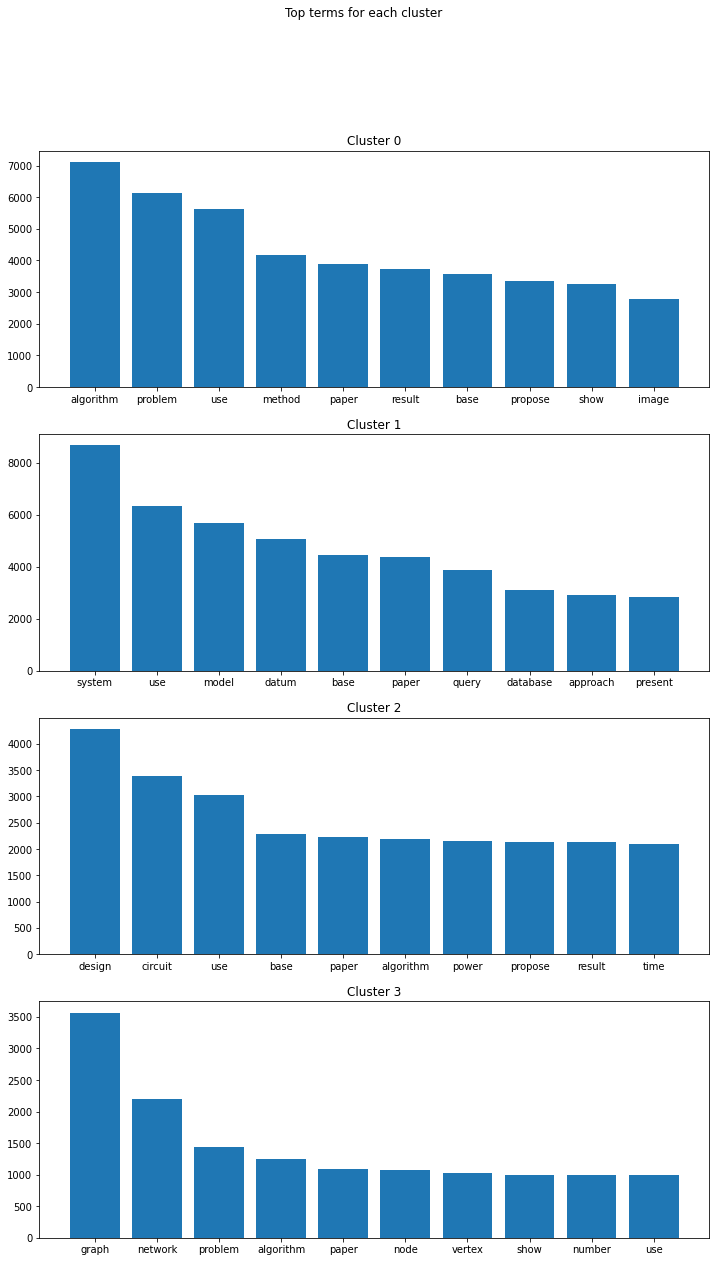

In [ ]:
# top terms for each cluster
fig, axes = plt.subplots(4)
fig.suptitle('Top terms for each cluster')
fig.set_figwidth(12)
fig.set_figheight(20)
for i in range(4):
  df_cluster = df.loc[np.array(spherical_kmeans.labels_)==i, :]
  corpus = df_cluster.copy().iloc[:,6]
  texts = " ".join(corpus)
  
  corp = texts.split()
  freq = nltk.FreqDist(corp)
  dict_freq = {}
  for key, value in freq.items():
    dict_freq[key] = [key, value]

  data_frame_freq = pd.DataFrame(dict_freq)
  data_frame_freq = data_frame_freq.transpose()
  data_frame_freq.columns = ['word','count']
  data_frame_freq = data_frame_freq.sort_values(by="count", ascending=False)
  axes[i].bar(data_frame_freq.iloc[:,0].values[:10], data_frame_freq.iloc[:,1].values[:10])
  axes[i].set_title(f"Cluster {i}")
plt.show()

In [ ]:
# Type of revues for each cluster
revues_names = []
revues_counts = []
for i in range(4):
  df_cluster = df.loc[np.array(spherical_kmeans.labels_)==i, :]
  print(f"The type of revues for the cluster {i} : {df_cluster.Publication.value_counts().keys()[0]}\n")


The type of revues for the cluster 0 : GECCO

The type of revues for the cluster 1 : Electr. Notes Theor. Comput. Sci.

The type of revues for the cluster 2 : DAC

The type of revues for the cluster 3 : Discrete Applied Mathematics



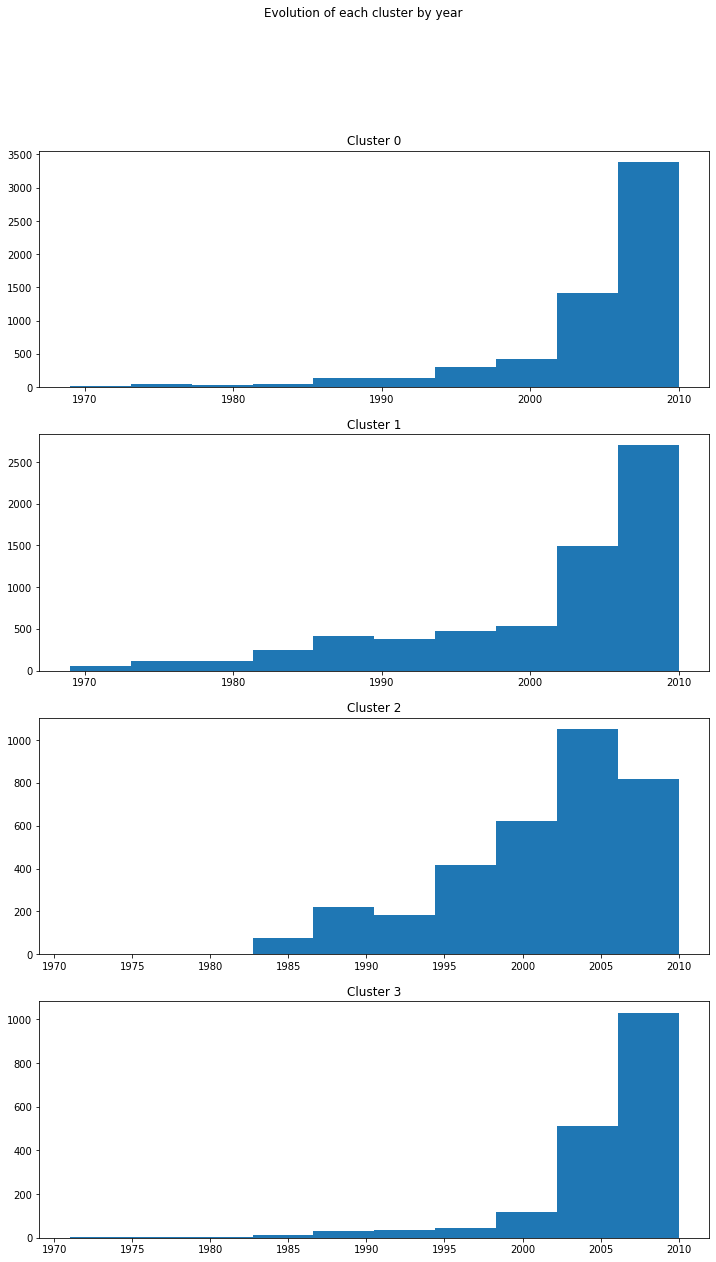

In [ ]:
# Evolution of each cluster by year
fig, axes = plt.subplots(4)
fig.suptitle('Evolution of each cluster by year')
fig.set_figwidth(12)
fig.set_figheight(20)
for i in range(4):
  df_cluster = df.loc[np.array(spherical_kmeans.labels_)==i, :]
  axes[i].hist(df_cluster.Year.values)
  axes[i].set_title(f"Cluster {i}")
plt.show()

In [ ]:
# Number of citations(references) for each cluster
citations = []
for i in range(4):
  df_cluster = df.loc[np.array(spherical_kmeans.labels_)==i, :]
  n = 0
  for citation in df_cluster.References.values:
    citation = str(citation)
    citation = citation.split()
    n+=len(citation)
  citations.append(n)
px.bar(x=[f'Cluster {i}' for i in range(4)], y=citations, title="Number of citations for each cluster")

## Bag of words of authors

In [ ]:
vocab = []
for i in range(len(df.Authors)):
  for j in df.Authors.values[i].split(','):
      vocab.append(j)
vocab = set(vocab)

In [ ]:
vocab

{'Alan Gibbons',
 'Einar J. Aas',
 'Olena Tankyevych',
 'Masayuki Sakoda',
 'Ronald J. Brachman',
 'P. Sean Stetson',
 'Wei Li 0013',
 'Dirk Räbiger',
 'Emilio Tuosto',
 'Angel Fernando Kuri Morales',
 'Falk Bartels',
 'Akira Hattori',
 'Zhang Yi',
 'Hagit Hel-Or',
 'Evgeniy Gabrilovich',
 'Ji Ruan',
 'Hiromasa Hoshino',
 'Linda van Norden',
 'Chia-Hao Lee',
 'Erwan Le Martelot',
 'Chung Wu',
 'Bjoern H. Menze',
 'Vahid Rafe',
 'Sanglu Lu',
 'Manuel Cardós',
 'Keun-dong Lee',
 'Abderrafiaa Koukam',
 'C. Bullwinkle',
 'Tong Xiao',
 'Fabio Campoccia',
 'Tie Zhong',
 'Kayhan Küçükçakar',
 'Bruce Hajek',
 'Mikko T. Siponen',
 'Iraj Saniee',
 'Shunsuke Miyamoto',
 'Agustin Riscos-Núñez',
 'Ginés Moreno',
 'Gerson Zaverucha',
 'Paul Tafertshofer',
 'Zeev Volkovich',
 'Henry Song',
 'David Overhauser',
 'Lihua Liu',
 'Koji Sato',
 'A. K. M. Khaled Ahsan Talukder',
 'Thomas Stibor',
 'Seon-Ho Park',
 'Chitta Baral',
 'Jim Aiken',
 'Eugene Szedenits Jr.',
 'Norman Wilde',
 'Tor Guimaraes',
 'Ro

In [ ]:
vectorizer = CountVectorizer(vocabulary=vocab)
corpus = df.Authors.values
X_bag_of_word_authors = vectorizer.fit_transform(corpus)
X_bag_of_word_authors.toarray().shape

(17633, 28729)

In [ ]:
vectorizer.vocabulary_

{'A-Xing Zhu': 0,
 'A. A. Makhnev': 1,
 'A. AbdelTawab': 2,
 'A. Antony Franklin': 3,
 'A. Attila Islier': 4,
 'A. Aydin Alatan': 5,
 'A. Baki Kocaballi': 6,
 'A. Baliga': 7,
 'A. Bolour': 8,
 'A. C. Rajeev': 9,
 'A. Caranti': 10,
 'A. D. Klamargias': 11,
 'A. De Wispelaere': 12,
 'A. E. Eiben': 13,
 'A. El Hibaoui': 14,
 'A. Emre Harmanci': 15,
 'A. Enis Çetin': 16,
 'A. Exeler': 17,
 'A. Grbic': 18,
 'A. Guénoche': 19,
 'A. H. I. Lee': 20,
 'A. H. Watt': 21,
 'A. Henni': 22,
 'A. Inkeri Verkamo': 23,
 'A. J. Dammers': 24,
 'A. J. M. M. Weijters': 25,
 'A. J. Scott': 26,
 'A. J. van Leeuwen': 27,
 'A. J. van Zanten': 28,
 'A. Judson Braga': 29,
 'A. K. M. Khaled Ahsan Talukder': 30,
 'A. K. Platongy': 31,
 'A. Kasatkin': 32,
 'A. Kiessling': 33,
 'A. L. C. Cavalcanti': 34,
 'A. Lynn Abbott': 35,
 'A. Min Tjoa': 36,
 'A. Mounir Alaoui': 37,
 'A. N. M. Salman': 38,
 'A. N. Rajagopalan': 39,
 'A. Nadgir': 40,
 'A. Nakamura': 41,
 'A. Narayanan': 42,
 'A. Nowzari-Dalini': 43,
 'A. Nur Zin

In [ ]:
nb = 0
for i in range(len(df.Authors)):
  nb+=len(df.Authors.values[i].split(', '))
nb

17633

In [ ]:
vectorizer.vocabulary_

{'A-Xing Zhu': 0,
 'A. A. Makhnev': 1,
 'A. AbdelTawab': 2,
 'A. Antony Franklin': 3,
 'A. Attila Islier': 4,
 'A. Aydin Alatan': 5,
 'A. Baki Kocaballi': 6,
 'A. Baliga': 7,
 'A. Bolour': 8,
 'A. C. Rajeev': 9,
 'A. Caranti': 10,
 'A. D. Klamargias': 11,
 'A. De Wispelaere': 12,
 'A. E. Eiben': 13,
 'A. El Hibaoui': 14,
 'A. Emre Harmanci': 15,
 'A. Enis Çetin': 16,
 'A. Exeler': 17,
 'A. Grbic': 18,
 'A. Guénoche': 19,
 'A. H. I. Lee': 20,
 'A. H. Watt': 21,
 'A. Henni': 22,
 'A. Inkeri Verkamo': 23,
 'A. J. Dammers': 24,
 'A. J. M. M. Weijters': 25,
 'A. J. Scott': 26,
 'A. J. van Leeuwen': 27,
 'A. J. van Zanten': 28,
 'A. Judson Braga': 29,
 'A. K. M. Khaled Ahsan Talukder': 30,
 'A. K. Platongy': 31,
 'A. Kasatkin': 32,
 'A. Kiessling': 33,
 'A. L. C. Cavalcanti': 34,
 'A. Lynn Abbott': 35,
 'A. Min Tjoa': 36,
 'A. Mounir Alaoui': 37,
 'A. N. M. Salman': 38,
 'A. N. Rajagopalan': 39,
 'A. Nadgir': 40,
 'A. Nakamura': 41,
 'A. Narayanan': 42,
 'A. Nowzari-Dalini': 43,
 'A. Nur Zin

In [ ]:
?CountVectorizer

In [ ]:
df.Authors.values

array(['Chung-Kuan Cheng,David N. Deutsch',
       'Lei Cheng,Liang Deng,Deming Chen,Martin D. F. Wong',
       'Kwang-Ting Cheng,Hi-Keung Tony Ma', ...,
       'Rossella Fortuna,Luigi Alfredo Grieco,Gennaro Boggia,Pietro Camarda',
       'Richard Werner Nelem Pazzi,Zhenxia Zhang,Azzedine Boukerche',
       'Liang Zhao,Ahmed Yassin Al-Dubai,Geyong Min'], dtype=object)

# Entity linking

In [ ]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("entityLinker", last=True)

In [ ]:
# Get entity and the name
listEntity = []
abstracts = df.iloc[:,6].values
for a, abs in enumerate(abstracts):
  doc = nlp(str(abs))
  listInter = []
  for sent in doc.sents:
    for i in range(len(sent._.linkedEntities)):
      entity_id = sent._.linkedEntities[i].get_id()
      entity_name = sent._.linkedEntities[i].get_label()
      listInter.append((entity_id, entity_name))
  listEntity.append(listInter)

In [ ]:
# Get entities in the first document
listEntity[0]

[(11500, 'area'),
 (6865248, 'minification'),
 (1604733, 'chemise'),
 (4440864, 'dimension'),
 (22725, 'routing'),
 (551997, 'wire'),
 (5447188, 'solution'),
 (2995644, 'result'),
 (816747, 'benchmark'),
 (12335479, 'template'),
 (690194, 'suggestion'),
 (42213, 'work')]

In [ ]:
# vectorizer
abstracts_entities_label = []
for i in range(len(listEntity)):
  doc_entities = []
  for entity in listEntity[i]:
    doc_entities.append(str(entity[1])) # to get the entity name
  abstracts_entities_label.append(" ".join(doc_entities))

vectorizer_entityLinking = CountVectorizer()
X_entity_linking = vectorizer_entityLinking.fit_transform(abstracts_entities_label)
X_entity_linking.toarray().shape

(17633, 9082)